In [59]:
import json
import os.path
from os.path import join

import skimage.draw as draw

#### Load training VIA annotator export file
- I exported annotations in the json format

In [60]:
data_dir = '/home/young/Pictures/orange_field_views/train'

# it expects all training images in this directory
image_dir = join(data_dir, 'images')

# generated mask images are stored in this directory
mask_dir = join(data_dir, 'masks')

# exported 'Annotation' as '(as json)'
annot_json_path = join(data_dir, 'orange_instance_segmentation_json.json')
annots = json.load(open(annot_json_path))

In [61]:
# '87.png' has 6 orange instances in it (and also many regions)

# annots['87.png226388']['regions']

for k, v in annots.items():
    if k.startswith('75.png'):
        print(k, v)

75.png220302 {'filename': '75.png', 'size': 220302, 'regions': [{'shape_attributes': {'name': 'polyline', 'all_points_x': [4, 9, 9, 5, 1, 1], 'all_points_y': [1, 8, 15, 18, 20, 1]}, 'region_attributes': {'orange': '0'}}], 'file_attributes': {}}


#### generate mask images
- using annotations
- it uses the same filename with the training images
    - but stored in the annotation directory `mask_dir`

In [62]:
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import numpy as np


for k, annot in annots.items():
    filename = annot['filename']
    img = Image.open(join(image_dir, filename))
    w, h = img.size

    try:
        mask = np.zeros((h, w, 3), dtype=np.uint8)

        for region in annot['regions']:
            shape_attr = region['shape_attributes']
            region_attr = region['region_attributes']

            instance_number = int(region_attr['orange'])
            if shape_attr['name'] == 'circle':
                cx, cy, radius = shape_attr['cx'], shape_attr['cy'], shape_attr['r']
                rr, cc = draw.ellipse(cy, cx, radius, radius, shape=(h, w))
            elif shape_attr['name'] in ['polygon', 'polyline']:
                xs = shape_attr['all_points_x']
                ys = shape_attr['all_points_y']
                rr, cc = draw.polygon(ys, xs, shape=(h, w))

            # all oranges
            mask[rr, cc, 0] = 1
            # instance
            mask[rr, cc, 1] = instance_number

        mask_img = Image.fromarray(mask)
        mask_img.save(join(mask_dir, filename))
    except ValueError as e:
        print(filename)
        raise e

# print(regions)


In [63]:
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
# this is a custom module!
import transforms as T

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### takes only images have at least one region in them
- I have only orange regions if any.
    - but it could a polyline or circle

In [64]:
# Glob from torch_snippets
all_images = Glob(image_dir)
all_annots = Glob(mask_dir)

orange_items = []

for _, annot in annots.items():
    if len(annot['regions']) > 0:
        orange_items.append(annot['filename'])

# only stems of image files!
items = stems(orange_items)

#### just checking if a mask looks OK

[0 1]


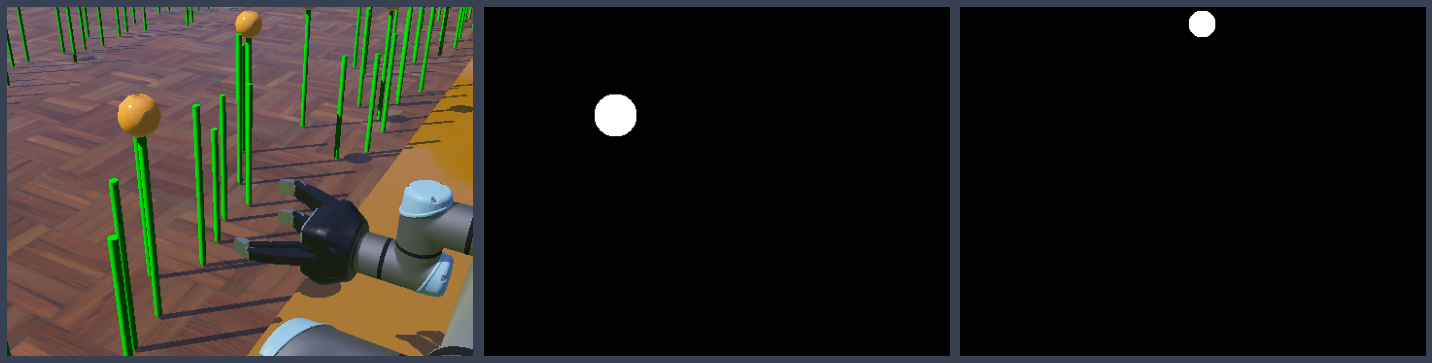

In [65]:
filename = '7.png'

# input image
im = read(join(image_dir, filename), 1)

# annotation image shape = (3, H, W)
an = read(join(mask_dir, filename), 1).transpose(2, 0, 1)
r, g, b = an

# r indicates the class
# like semantic segmentation annotations?
nzs = np.nonzero(r == 1)  # 1 stands for orange
# it is equivalent to
# nzs = np.where(r == 1)

# g is an instance segmentation indicator
# b is not used
# `instances` is the number of people in the input image!
instances = np.unique(g[nzs])
print(instances)

# the shape of maks = (# of instances, H, W)
# what is the dtype? it's float64.
masks = np.zeros((len(instances), *r.shape))
for ix, _id in enumerate(instances):
    masks[ix] = (r == 1) & (g == _id)

subplots([im, *masks], sz=20)

#### load test VIA annotator export
- in `test` directory
- `orange_instance_segmentation_test_json.json` annotation file

In [66]:
test_data_dir = '/home/young/Pictures/orange_field_views/test'

# it expects all training images in this directory
test_image_dir = join(test_data_dir, 'images')

# generated mask images are stored in this directory
test_mask_dir = join(test_data_dir, 'masks')

# exported 'Annotation' as '(as json)'
test_annot_json_path = join(test_data_dir, 'orange_instance_segmentation_test_json.json')
test_annots = json.load(open(test_annot_json_path))

In [67]:
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import numpy as np


for k, annot in test_annots.items():
    filename = annot['filename']
    img = Image.open(join(test_image_dir, filename))
    w, h = img.size

    try:
        mask = np.zeros((h, w, 3), dtype=np.uint8)

        for region in annot['regions']:
            shape_attr = region['shape_attributes']
            region_attr = region['region_attributes']

            instance_number = int(region_attr['orange'])
            if shape_attr['name'] == 'circle':
                cx, cy, radius = shape_attr['cx'], shape_attr['cy'], shape_attr['r']
                rr, cc = draw.ellipse(cy, cx, radius, radius, shape=(h, w))
            elif shape_attr['name'] in ['polygon', 'polyline']:
                xs = shape_attr['all_points_x']
                ys = shape_attr['all_points_y']
                rr, cc = draw.polygon(ys, xs, shape=(h, w))

            # all oranges
            mask[rr, cc, 0] = 1
            # instance
            mask[rr, cc, 1] = instance_number

        mask_img = Image.fromarray(mask)
        mask_img.save(join(test_mask_dir, filename))
    except ValueError as e:
        print(filename)
        raise e

[0]


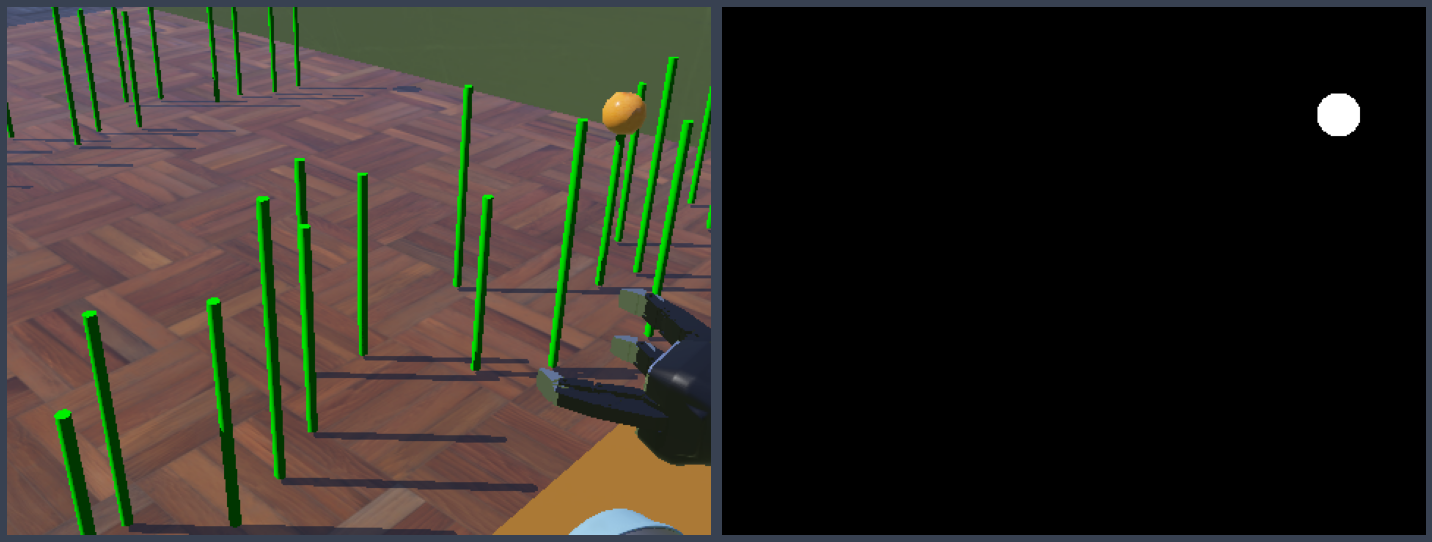

In [68]:
filename = '7.png'

# input image
im = read(join(test_image_dir, filename), 1)

# annotation image shape = (3, H, W)
an = read(join(test_mask_dir, filename), 1).transpose(2, 0, 1)
r, g, b = an

# r indicates the class
# like semantic segmentation annotations?
nzs = np.nonzero(r == 1)  # 1 stands for orange
# it is equivalent to
# nzs = np.where(r == 1)

# g is an instance segmentation indicator
# b is not used
# `instances` is the number of people in the input image!
instances = np.unique(g[nzs])
print(instances)

# the shape of maks = (# of instances, H, W)
# what is the dtype? it's float64.
masks = np.zeros((len(instances), *r.shape))
for ix, _id in enumerate(instances):
    masks[ix] = (r == 1) & (g == _id)

subplots([im, *masks], sz=20)

In [69]:
def get_transform(train):
    transforms = []
    # note that T is not torchvision.transforms
    transforms.append(T.ToTensor())
    
    if train:
        # here T is not torchvision.transforms!
        transforms.append(T.RandomHorizontalFlip(0.5))

    # note that T is not torchvision.transforms
    return T.Compose(transforms)

In [70]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, data_path):
        """
        Args:
            items (List[str]): stem of input and annotation images (masks)
            transforms:
            N (int): the length of this Dataset
        """
        self.items = items
        self.transforms = transforms
        self.data_path = data_path

    def get_mask(self, path):
        """
        this method could be static
        """
        # torch_snippets.loader.read uses cv2.imread
        # mode = 1 returns an image in a RGB format
        # pytorch requires the color channel first. Thus, transpose
        an = read(path, 1).transpose(2, 0, 1)
        
        # this only possible when the color channel comes first
        r, g, b = an
        
        # r == 1 => all orange instances!
        nzs = np.nonzero(r == 1)
        
        # my annotations starts from 0
        instances = np.unique(g[nzs])
        
        # the shape of mask is (# of oranges, H, W)
        masks = np.zeros((len(instances), *r.shape))

        for ix, _id in enumerate(instances):
            masks[ix] = (r == 1) & (g == _id)

        return masks

    def __getitem__(self, ix):
        """
        this method gives only a 'person' class sample
        
        Returns:
            (image, dict of list of boxes, labels, masks, etc)
        """
        # _id is stem
        _id = self.items[ix]
        img_path = join(self.data_path, 'images', f'{_id}.png')
        mask_path = join(self.data_path, 'masks', f'{_id}.png')
        
        # masks.shape = (# of people, H, W)
        masks = self.get_mask(mask_path)
#         obj_ids = np.arange(1, len(masks) + 1)
#         num_objs = len(obj_ids)
        num_objs = len(masks)
        
        # input image shape = (3, H, W)
        img = Image.open(img_path).convert("RGB")
        
        # this bounding boxes are calculated from masks
        # # of boxes == # of people
        boxes = []
        for i in range(num_objs):
            # non-zero pixel indices
            obj_pixels = np.where(masks[i])
            
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            
            if ((xmax - xmin) <= 10) | (ymax - ymin) <= 10:
                xmax = xmin + 10
                ymax = ymin + 10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # we have only one non-background (person) class in this dataset
        # thus, labels are all 1
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        # shape = (# of people, H, W)
        # does python require masks be uint8 tensors?
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        # shape = (# of people,)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # what is 'iscrowd'?
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        # image_id should be a uint64 tensor?
        image_id = torch.tensor([ix])
        
        target = {"boxes": boxes, "labels": labels, "masks": masks,
                  "image_id": image_id, "area": area, "iscrowd": iscrowd}

        # just a unique number? shape = (1,)

        if self.transforms is not None:
            # it transforms also all images in `target` too?
            img, target = self.transforms(img, target)
        return img, target
    
    def __len__(self):
        return len(self.items)
    
    def choose(self):
        return self[randint(len(self))]

#### checking `MaskDataset`
- many stuffs in `target`

<class 'torch.Tensor'> torch.Size([3, 360, 480]) ['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd']
boxes dtype: torch.float32
labels dtype: torch.int64
masks dtype : torch.uint8
image_id: torch.int64
area: torch.float32
iscrowd: torch.int64


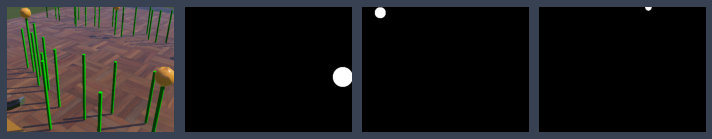

In [71]:
# trn_items are stems of image files
# MasksDataset gives a tuple of (image, dict of list of boxes, list of labels, list of masks, ...)
x = MasksDataset(items, get_transform(train=True), data_path=data_dir)

# the second image and its target
im, targ = x[1]
print(type(im), im.shape, list(targ.keys()))
# inspect(im, targ)

# except masks (torch.uint8) all integers are torch.uint64
print('boxes dtype:', targ['boxes'].dtype)
print('labels dtype:', targ['labels'].dtype)
print('masks dtype :', targ['masks'].dtype)

# since it's for a single image, a singular term makes sense
print('image_id:', targ['image_id'].dtype)
# why singular 'area'? not 'areas'
print('area:', targ['area'].dtype)
# why 'iscrowd' not ''
print('iscrowd:', targ['iscrowd'].dtype)

subplots([im, *targ['masks']], sz=10)

In [72]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model which is pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [73]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# use our dataset and defined transformations
dataset_trn = MasksDataset(items, get_transform(train=True), data_path=data_dir)
dataset_val = MasksDataset(items, get_transform(train=False), data_path=data_dir)

# split the dataset in train and test set
indices = torch.randperm(len(items)).tolist()

# about 8:2 training:validation split
val_size = int(len(indices) * 0.2)
dataset_trn = torch.utils.data.Subset(dataset_trn, indices[:-val_size])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-val_size:])

# define training and validation data loaders
# utils.collate_fn transforms
#    list of (imge, annotations) -> (list of images, list of annotations)
dl_trn = torch.utils.data.DataLoader(
    dataset_trn, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

dl_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

#### load parameters

In [74]:
num_classes = 2

model = get_model_instance_segmentation(num_classes)
model = model.to(device)
model.load_state_dict(torch.load('orange_mask_rcnn_10_epochs.pth'))

<All keys matched successfully>

In [16]:
from engine import train_one_epoch, evaluate
import utils


# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model = model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, dl_trn, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, dl_val, device=device)

    torch.save(model.state_dict(), f'orange_mask_rcnn_{epoch + 1}_epochs.pth')
print("That's it!")


Epoch: [0]  [ 0/61]  eta: 0:01:07  lr: 0.000088  loss: 11.9634 (11.9634)  loss_classifier: 0.6869 (0.6869)  loss_box_reg: 0.0789 (0.0789)  loss_mask: 11.0946 (11.0946)  loss_objectness: 0.1011 (0.1011)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 1.1104  data: 0.1395  max mem: 2133
Epoch: [0]  [10/61]  eta: 0:00:33  lr: 0.000921  loss: 1.2079 (3.5845)  loss_classifier: 0.2579 (0.3636)  loss_box_reg: 0.0789 (0.1044)  loss_mask: 0.7846 (3.0395)  loss_objectness: 0.0678 (0.0740)  loss_rpn_box_reg: 0.0019 (0.0030)  time: 0.6609  data: 0.0185  max mem: 2407
Epoch: [0]  [20/61]  eta: 0:00:26  lr: 0.001753  loss: 0.8625 (2.2110)  loss_classifier: 0.1659 (0.2577)  loss_box_reg: 0.1177 (0.1361)  loss_mask: 0.4894 (1.7514)  loss_objectness: 0.0318 (0.0614)  loss_rpn_box_reg: 0.0029 (0.0044)  time: 0.6177  data: 0.0051  max mem: 2407
Epoch: [0]  [30/61]  eta: 0:00:19  lr: 0.002586  loss: 0.5923 (1.6786)  loss_classifier: 0.1286 (0.2167)  loss_box_reg: 0.2217 (0.1767)  loss_mask: 0.1580 (1.2341)  los

Epoch: [2]  [ 0/61]  eta: 0:01:47  lr: 0.005000  loss: 0.1611 (0.1611)  loss_classifier: 0.0295 (0.0295)  loss_box_reg: 0.0565 (0.0565)  loss_mask: 0.0709 (0.0709)  loss_objectness: 0.0041 (0.0041)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 1.7578  data: 0.1338  max mem: 2487
Epoch: [2]  [10/61]  eta: 0:01:15  lr: 0.005000  loss: 0.2312 (0.2941)  loss_classifier: 0.0326 (0.0491)  loss_box_reg: 0.0734 (0.0800)  loss_mask: 0.1238 (0.1590)  loss_objectness: 0.0024 (0.0050)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 1.4726  data: 0.0164  max mem: 2487
Epoch: [2]  [20/61]  eta: 0:00:58  lr: 0.005000  loss: 0.2263 (0.2670)  loss_classifier: 0.0326 (0.0464)  loss_box_reg: 0.0706 (0.0735)  loss_mask: 0.1154 (0.1402)  loss_objectness: 0.0014 (0.0052)  loss_rpn_box_reg: 0.0011 (0.0016)  time: 1.4013  data: 0.0044  max mem: 2487
Epoch: [2]  [30/61]  eta: 0:00:42  lr: 0.005000  loss: 0.2193 (0.2510)  loss_classifier: 0.0301 (0.0417)  loss_box_reg: 0.0611 (0.0703)  loss_mask: 0.1086 (0.1331)  loss_ob

Epoch: [4]  [ 0/61]  eta: 0:01:20  lr: 0.000500  loss: 0.1229 (0.1229)  loss_classifier: 0.0132 (0.0132)  loss_box_reg: 0.0209 (0.0209)  loss_mask: 0.0877 (0.0877)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 1.3236  data: 0.1107  max mem: 2487
Epoch: [4]  [10/61]  eta: 0:01:07  lr: 0.000500  loss: 0.1444 (0.1798)  loss_classifier: 0.0197 (0.0355)  loss_box_reg: 0.0258 (0.0365)  loss_mask: 0.0922 (0.1014)  loss_objectness: 0.0016 (0.0054)  loss_rpn_box_reg: 0.0009 (0.0011)  time: 1.3159  data: 0.0138  max mem: 2487
Epoch: [4]  [20/61]  eta: 0:00:52  lr: 0.000500  loss: 0.1444 (0.1832)  loss_classifier: 0.0207 (0.0334)  loss_box_reg: 0.0313 (0.0369)  loss_mask: 0.0995 (0.1059)  loss_objectness: 0.0013 (0.0059)  loss_rpn_box_reg: 0.0008 (0.0011)  time: 1.2656  data: 0.0043  max mem: 2487
Epoch: [4]  [30/61]  eta: 0:00:41  lr: 0.000500  loss: 0.1409 (0.1737)  loss_classifier: 0.0219 (0.0299)  loss_box_reg: 0.0277 (0.0382)  loss_mask: 0.0883 (0.1002)  loss_ob

Epoch: [6]  [ 0/61]  eta: 0:00:57  lr: 0.000050  loss: 0.1700 (0.1700)  loss_classifier: 0.0290 (0.0290)  loss_box_reg: 0.0451 (0.0451)  loss_mask: 0.0931 (0.0931)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 0.9490  data: 0.1097  max mem: 2487
Epoch: [6]  [10/61]  eta: 0:00:50  lr: 0.000050  loss: 0.1538 (0.1903)  loss_classifier: 0.0259 (0.0369)  loss_box_reg: 0.0451 (0.0491)  loss_mask: 0.0902 (0.1011)  loss_objectness: 0.0012 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0008)  time: 0.9835  data: 0.0137  max mem: 2487
Epoch: [6]  [20/61]  eta: 0:00:39  lr: 0.000050  loss: 0.1538 (0.1854)  loss_classifier: 0.0238 (0.0352)  loss_box_reg: 0.0361 (0.0468)  loss_mask: 0.0900 (0.0989)  loss_objectness: 0.0012 (0.0035)  loss_rpn_box_reg: 0.0007 (0.0011)  time: 0.9649  data: 0.0040  max mem: 2487
Epoch: [6]  [30/61]  eta: 0:00:30  lr: 0.000050  loss: 0.1531 (0.1793)  loss_classifier: 0.0204 (0.0340)  loss_box_reg: 0.0376 (0.0456)  loss_mask: 0.0851 (0.0955)  loss_ob

Epoch: [8]  [ 0/61]  eta: 0:01:37  lr: 0.000050  loss: 0.3953 (0.3953)  loss_classifier: 0.0895 (0.0895)  loss_box_reg: 0.0461 (0.0461)  loss_mask: 0.2515 (0.2515)  loss_objectness: 0.0066 (0.0066)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 1.6028  data: 0.1202  max mem: 2487
Epoch: [8]  [10/61]  eta: 0:01:13  lr: 0.000050  loss: 0.1804 (0.2031)  loss_classifier: 0.0340 (0.0343)  loss_box_reg: 0.0461 (0.0515)  loss_mask: 0.0971 (0.1143)  loss_objectness: 0.0013 (0.0020)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 1.4420  data: 0.0147  max mem: 2487
Epoch: [8]  [20/61]  eta: 0:00:59  lr: 0.000050  loss: 0.1648 (0.1919)  loss_classifier: 0.0254 (0.0349)  loss_box_reg: 0.0349 (0.0443)  loss_mask: 0.0887 (0.1073)  loss_objectness: 0.0012 (0.0044)  loss_rpn_box_reg: 0.0004 (0.0010)  time: 1.4474  data: 0.0042  max mem: 2487
Epoch: [8]  [30/61]  eta: 0:00:44  lr: 0.000050  loss: 0.1448 (0.1815)  loss_classifier: 0.0218 (0.0324)  loss_box_reg: 0.0322 (0.0404)  loss_mask: 0.0826 (0.1035)  loss_ob

That's it!


image shape = torch.Size([3, 360, 480])
target keys: dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])
pred key names : dict_keys(['boxes', 'labels', 'scores', 'masks'])
boxes: [[324.29337  194.68509  380.00314  250.09749 ]
 [468.8541    16.168867 479.11227   45.615845]
 [323.3814   198.0146   354.78748  244.69328 ]]
scores: tensor([0.9988, 0.9867, 0.0530], device='cuda:0', grad_fn=<IndexBackward0>)
labels: tensor([1, 1, 1], device='cuda:0')
mask shape: torch.Size([3, 1, 360, 480])


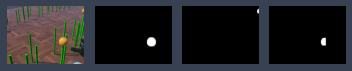

In [106]:
model.eval()
# model(dataset[0][0])

img, target = dataset_test[19]
print('image shape =', img.shape)
print('target keys:', target.keys())

# only one sample
pred, = model(img.unsqueeze(dim=0).to(device))
print('pred key names :', pred.keys())

# one box per instance
# print(pred['boxes'].shape)
print('boxes:', pred['boxes'].cpu().detach().numpy())

# the model gives only the scores for the most probable labels
#     not the scores for all classes
# thus, the shape = (# of instances,)
print('scores:', pred['scores'])

# does the model ever give 0 (background) labels?
print('labels:', pred['labels'])

print('mask shape:', pred['masks'].shape)

# note that subplots can't draw a single image!
# draw all masks that have scores greater than 0.5
subplots([img, *[x[0] for x, s in zip(pred['masks'], pred['scores']) if s > 0.05]])

In [108]:
target['masks']
# b = t_mask.detach().cpu().numpy() > 0.5
# i = np.sum(a * b)
# u = np.sum(a) + np.sum(b) - i

# iou = i / u

torch.Size([3, 360, 480])

In [18]:
print(len(items))

151


In [23]:
torch.save(model.state_dict(), 'orange_mask_rcnn_10_epochs.pth')

In [25]:
!ls -lah *.pth

-rw-rw-r-- 1 young young 169M Apr  9 12:58 orange_mask_rcnn_10_epochs.pth


#### Evaluation
- IoU (Jaccard index) might be adequate for semantic segmentation
- what metrics should I use for instance segmentations?

In [94]:
# Glob from torch_snippets
all_test_images = Glob(test_image_dir)
all_test_annots = Glob(test_mask_dir)

orange_test_items = []

for _, annot in test_annots.items():
    if len(annot['regions']) > 0:
        orange_test_items.append(annot['filename'])

# only stems of image files!
test_items = stems(orange_test_items)


dataset_test = MasksDataset(test_items, get_transform(train=False), data_path=test_data_dir)

img_indices = []
gt_score = []
pred_score = []
pred_ious = []

for img_idx, (img, target) in enumerate(dataset_test):
#     img, target = dataset_test[0]
    pred, = model(img.unsqueeze(dim=0).to(device))

#     print(pred['masks'].shape)
#     print(torch.max(target['masks']))

    img_gt_score = [[] for _ in range(len(target['masks']))]

    pred = {k: v.detach().cpu().numpy() for k, v in pred.items()}

    for p_mask, p_score in zip(pred['masks'], pred['scores']):
        # maximum iou of this pred mask for any of gt masks
        max_iou = 0

        for idx, t_mask in enumerate(target['masks']):
            a = p_mask[0] > 0.5
            b = t_mask.detach().cpu().numpy() > 0.5
            i = np.sum(a * b)
            u = np.sum(a) + np.sum(b) - i
            
            iou = i / u
            
            # we're doing AP@0.5
            if iou > 0.5:
                img_gt_score[idx].append(p_score)
            
            if iou > max_iou:
                max_iou = i / u

        pred_score.append(p_score)
        pred_ious.append(max_iou)
    
    gt_score.extend(img_gt_score)
    img_indices.extend([img_idx] * len(img_gt_score))


In [77]:
# len(gt_score) is the number of all orange instances
# len(pre_dcore) is the number of predictions!
pred_score = np.asarray(pred_score)
pred_ious = np.asarray(pred_ious)

print(len(pred_score), len(pred_ious), len(gt_score))

precisions = []
recalls = []

p_thresholds = np.linspace(0.0, 0.999, 1000)

for pt in p_thresholds:
    recall = sum([1 if [x for x in score if x > pt] else 0 for score in gt_score]) / len(gt_score)
    precision = np.mean(pred_ious[pred_score > pt] > 0.5)
    precisions.append(precision)
    recalls.append(recall)
    

77 77 52


(0.0, 1.05)

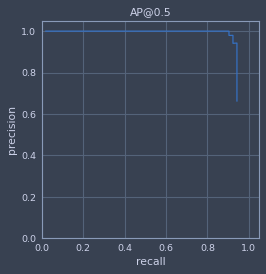

In [78]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

ax.plot(recalls, precisions)

ax.set_title('AP@0.5')
ax.set_xlabel('recall')
ax.set_ylabel('precision')

ax.set_xlim(0, 1.05)
ax.set_ylim(0, 1.05)

# print(recalls[0], recalls[-1])
# print(precisions[0], precisions[-1])

In [104]:
[(np.max(x), idx) if x else (0, idx) for x, idx in zip(gt_score, img_indices)]

[(0.9986902, 0),
 (0.9989489, 0),
 (0.998271, 1),
 (0.99784875, 1),
 (0.99653625, 2),
 (0.99670523, 3),
 (0.95384824, 4),
 (0.99816304, 5),
 (0.998524, 5),
 (0.99862945, 6),
 (0.22348282, 6),
 (0.58059114, 6),
 (0.9865102, 7),
 (0.9297854, 7),
 (0.9985599, 8),
 (0.99720025, 9),
 (0.99876606, 10),
 (0.998384, 11),
 (0.99750924, 11),
 (0.9920027, 11),
 (0.99833137, 12),
 (0.99893194, 13),
 (0.9987942, 13),
 (0.9988249, 14),
 (0.9952643, 15),
 (0.99572647, 16),
 (0.9982033, 17),
 (0.9974794, 17),
 (0.99816173, 18),
 (0.9981346, 18),
 (0.99710494, 18),
 (0.99881124, 19),
 (0.98667127, 19),
 (0, 19),
 (0.99869823, 20),
 (0.99810326, 20),
 (0.9958716, 20),
 (0, 20),
 (0.998796, 21),
 (0.99906737, 22),
 (0.9984604, 23),
 (0.99839395, 23),
 (0.99804986, 24),
 (0.9981997, 24),
 (0.9975331, 25),
 (0.9980599, 26),
 (0.99823976, 27),
 (0, 28),
 (0.9970897, 29),
 (0.9934968, 29),
 (0.9978453, 30),
 (0.998288, 30)]